In [1]:
import sys
import os

env = "colab" # "colab" or "local"

if env == "colab":
    %cd /content/sample_data/
    !git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git
    path = '/content/sample_data/scisciJP2024_tutorial'
if env == "local":
    path = 'YOUR_PATH'

sys.path.append(path)
print(os.getcwd())

os.chdir(path)
sys.path

/Users/ti/Documents/code/scisciJP2024_tutorial/examples


['/Users/ti/Documents/code/scisciJP2024_tutorial/examples',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/ti/Library/Python/3.9/lib/python/site-packages',
 '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages',
 '/Users/ti/Documents/code/scisciJP2024_tutorial/']

In [2]:
%pip install pyalex 
%pip install japanize_matplotlib 
from pyalex import Works, Authors, Sources, Institutions, Concepts, Funders
import pyalex

import pandas as pd
import numpy as np
import math
import tqdm
import matplotlib.pyplot as plt
import japanize_matplotlib

import util

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Users/ti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
pyalex.config.email = "your@email.address"

In [170]:
country = "JP" # compare within Japan.
# 例：地震学
topics = [
    10001, #Tectonic and Geochronological Evolution of Orogens
    10110, #Seismicity and Tectonic Plate Interactions
    10271, #Seismic Waveform Inversion in Geophysics
    10413, #Mantle Dynamics and Earth's Structure
    11757, #High-Resolution Seismic Noise Tomography
]

In [171]:
# pyalexObj = Institutions().filter(country_code=country).select(["id", "display_name", "cited_by_count"])
# result = util.getAll(pyalexObj)
# institutions_df = pd.DataFrame(result)
# institutions_df.to_pickle("./supplementary/institutions_df.pickle")
institutions_df = pd.read_pickle("./supplementary/institutions_df.pickle")

Fetching 3914 objects. it may takes 19.57 to 58.71 seconds
Fetching 3914 objects. it may takes 0.33 to 0.98 minutes


21it [00:16,  1.25it/s]


In [172]:
# 国内の相対的な組織のランキングではなく、組織内の個性、強み分析
# 組織内で成果が出ている分野と、インパクトを与えている分野の分析。

# 分野ごとに被引用数の平均が異なるため、単純に平均被引用数の平均や合計で比較しても、年間出版数の多い計算機科学で高い数値が、出版数の少ない遺伝子工学や数学などで低い数値が得られるだけとなる。
# Revealed Comperative Advantage(比較顕示優位)、つまり分野の被引用数の相対的な割合が、世界平均での割合と比べてどの程度高いかの比で、分野同士を比較できるようになる。
# 横軸に生産性(論文出版数のRCA)、縦軸にインパクト（被引用数のRCA）をとったプロットを描画する。
# 詳細は「研究評価・科学論のための科学計量学入門」(丸善株式会社)などを参照のこと。

citation_counts = pd.DataFrame()

for t in tqdm.tqdm(topics): 
    # 通常は引用数が安定するまで10年程度かかるため、2010年から2014年までの論文を対象とする。
    pyalexObj = Works().filter(
        from_publication_date="2010-01-01",to_publication_date="2014-12-31",\
        cited_by_count=">0",\
        authorships={"institutions":{"country_code":country}},\
        primary_topic={"id": "t"+str(t)}
    ).select([
        "id",
        "authorships",
        "cited_by_count"
    ])

    result = util.getAll(pyalexObj, verbous=False)
    for r in result:
        r["topic"] = t
        authorships = r["authorships"]
        authors = []
        for a in authorships:
            institution = a["institutions"]
            if len(institution)>0:
                institution_id = institution[0]["id"]
                if r.get("authors/institution/id", None) is None:
                    r["authors/institution/id"] = [institution_id]
                else:
                    r["authors/institution/id"].append(institution_id)
    
    citation_counts = pd.concat([citation_counts, pd.DataFrame(result)],axis=0)

citation_counts.shape[0] # 取得できた論文数

100%|██████████| 5/5 [00:44<00:00,  8.94s/it]


In [174]:
citation_count = citation_counts.explode(column=["authors/institution/id"])

institution_citation = citation_count.groupby(by="authors/institution/id").sum("cited_by_count").reset_index()
institution_citation = institution_citation.merge(institutions_df, left_on="authors/institution/id", right_on="id")
institution_citation["rca"] = institution_citation["cited_by_count_x"] / institution_citation["cited_by_count_y"] / (institution_citation["cited_by_count_x"].sum() / institution_citation["cited_by_count_y"].sum())
institution_citation = institution_citation.merge(citation_count["authors/institution/id"].value_counts(), left_on="authors/institution/id", right_index=True)

Text(0, 0.5, 'Impact')

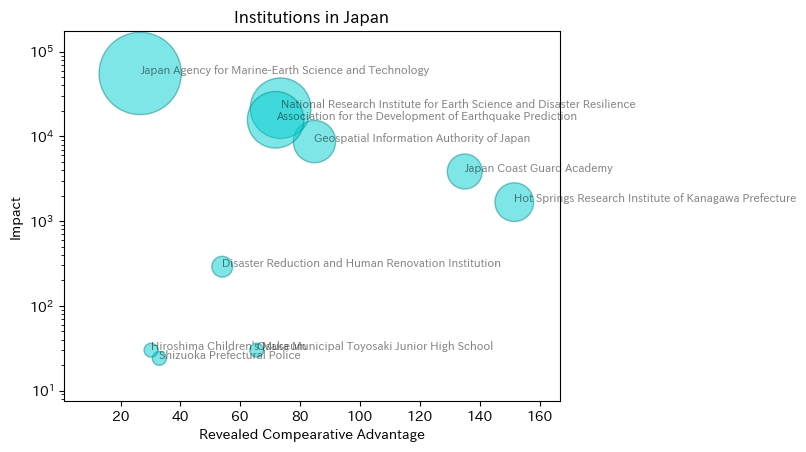

In [175]:
num_inst = 10
top_inst = institution_citation.sort_values(by="rca", ascending=False).head(num_inst)

x_range = (min(top_inst["rca"]), max(top_inst["rca"]))
y_range = (math.log10(min(top_inst["cited_by_count_x"])), math.log10(max(top_inst["cited_by_count_x"])))

# 大分類ごとの色を設定
dark_colors = ['olivedrab','orange' ,'darkcyan', 'orangered'] 
light_colors = [ 'yellowgreen', 'gold','darkturquoise','coral']
# colors = rca["domain_id_x"].apply(lambda x: light_colors[x-1])
# edgecolors = rca["domain_id_x"].apply(lambda x: dark_colors[x-1])

plt.scatter(top_inst["rca"], top_inst["cited_by_count_x"], s=top_inst["count"].apply(lambda x: math.sqrt(x)*100),c=light_colors[2],edgecolors=dark_colors[2], alpha=0.5)
labels = top_inst["display_name"]
for t, txt in enumerate(labels):
    plt.text(top_inst["rca"].iloc[t],top_inst["cited_by_count_x"].iloc[t] ,  txt, fontsize=8,alpha=0.5)

# plt.xscale("log")
plt.yscale("log")
plt.title(f"Institutions in Japan")
plt.xlim(1,x_range[1]*1.1)
plt.ylim(10**(y_range[0]-0.5),10**(y_range[1]+0.5))
plt.xlabel("Revealed Compearative Advantage")
plt.ylabel("Impact")